In [45]:
import json

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

import numpy as np

import openturns as ot
import openturns.viewer as viewer
import openturns.viewer as otv

plt.rcParams['figure.dpi']= 500
plt.rcParams['text.usetex'] = True

# Importing Data

In [46]:
# Color scheme for chemical conditioning
colors_n = {'C1': {'low': 'lightgreen', 'high': 'forestgreen'},
            'C2': {'high': 'slateblue'}}
colors_ch = {'C1': {'low': ['lightgreen', 0.05], 'high': ['forestgreen', 0.2]},
             'C2': {'high':['slateblue',  0.2]}}

In [47]:
labels = [
    r"$\alpha$",
    r"$\beta$",
    r"$\epsilon_e$",
    r"$\epsilon_c$",
    r"$d_p$",
    r"$\Gamma_{p}(0)$",
    r"$a_v$"
]

In [48]:
# Input-Output of THYC-Puffer-DEPOTHYC in Ho
# Hot leg
dataset_HL = ot.Sample.ImportFromCSVFile('../data/SG_MC_HL.csv')

In [35]:
# Time indices in days
t = np.load('../data/SG_time.npy')

In [36]:
# Input sample
inputSample = dataset_HL[:,:7]

In [37]:
# Clogging output as a function of time
outputSample = dataset_HL[:,7:]

In [38]:
# Parameters of the Steam Generator
input_dic = {}
input_dic['SG'] = json.load(open('../data/SG_cleaning_conditioning.json'))

## General $R^2_{HSIC}$

In [39]:
hsic_time_HL = []
estimatorType_u = ot.HSICUStat() 
p_values_HL = []

In [40]:
for i in range(75):
    
    tauSample_HL = outputSample[:,i]

    covarianceModelCollection_HL = []
    for i in range(7):
        Xi = inputSample.getMarginal(i)
        Cov = ot.SquaredExponential(1)
        Cov.setScale(Xi.computeStandardDeviation())
        covarianceModelCollection_HL.append(Cov)

    covarianceModelCollection_HL.append(ot.SquaredExponential(tauSample_HL.computeStandardDeviation()))

    hsic_u_HL = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection_HL, inputSample, tauSample_HL, estimatorType_u)

    hsic_time_HL.append(list(np.abs(hsic_u_HL.getR2HSICIndices())))

    #Permutation-based test
    #hsic_u_HL.setPermutationSize(500)
    #p_values_HL.append(hsic_u_HL.getPValuesPermutation())
    
    #Asymptotic test 1
    p_values_HL.append(hsic_u_HL.getPValuesAsymptotic())

    #Asymptotic test 2
    #_p_HL = []
    #for j in range(7):
    #    _p_HL.append(round(estimatorType_u.computePValue(ot.Gamma(), 1000, hsic_u_HL.getHSICIndices()[j], 0.0),4))
    #p_values_HL.append(_p_HL)

In [41]:
hsic_time_HL = np.asarray(list(np.transpose(np.asarray(hsic_time_HL))))
p_values_HL = np.transpose(np.asarray(p_values_HL))

In [42]:
p_values_HL.shape

(7, 75)

In [43]:
t=list(t)

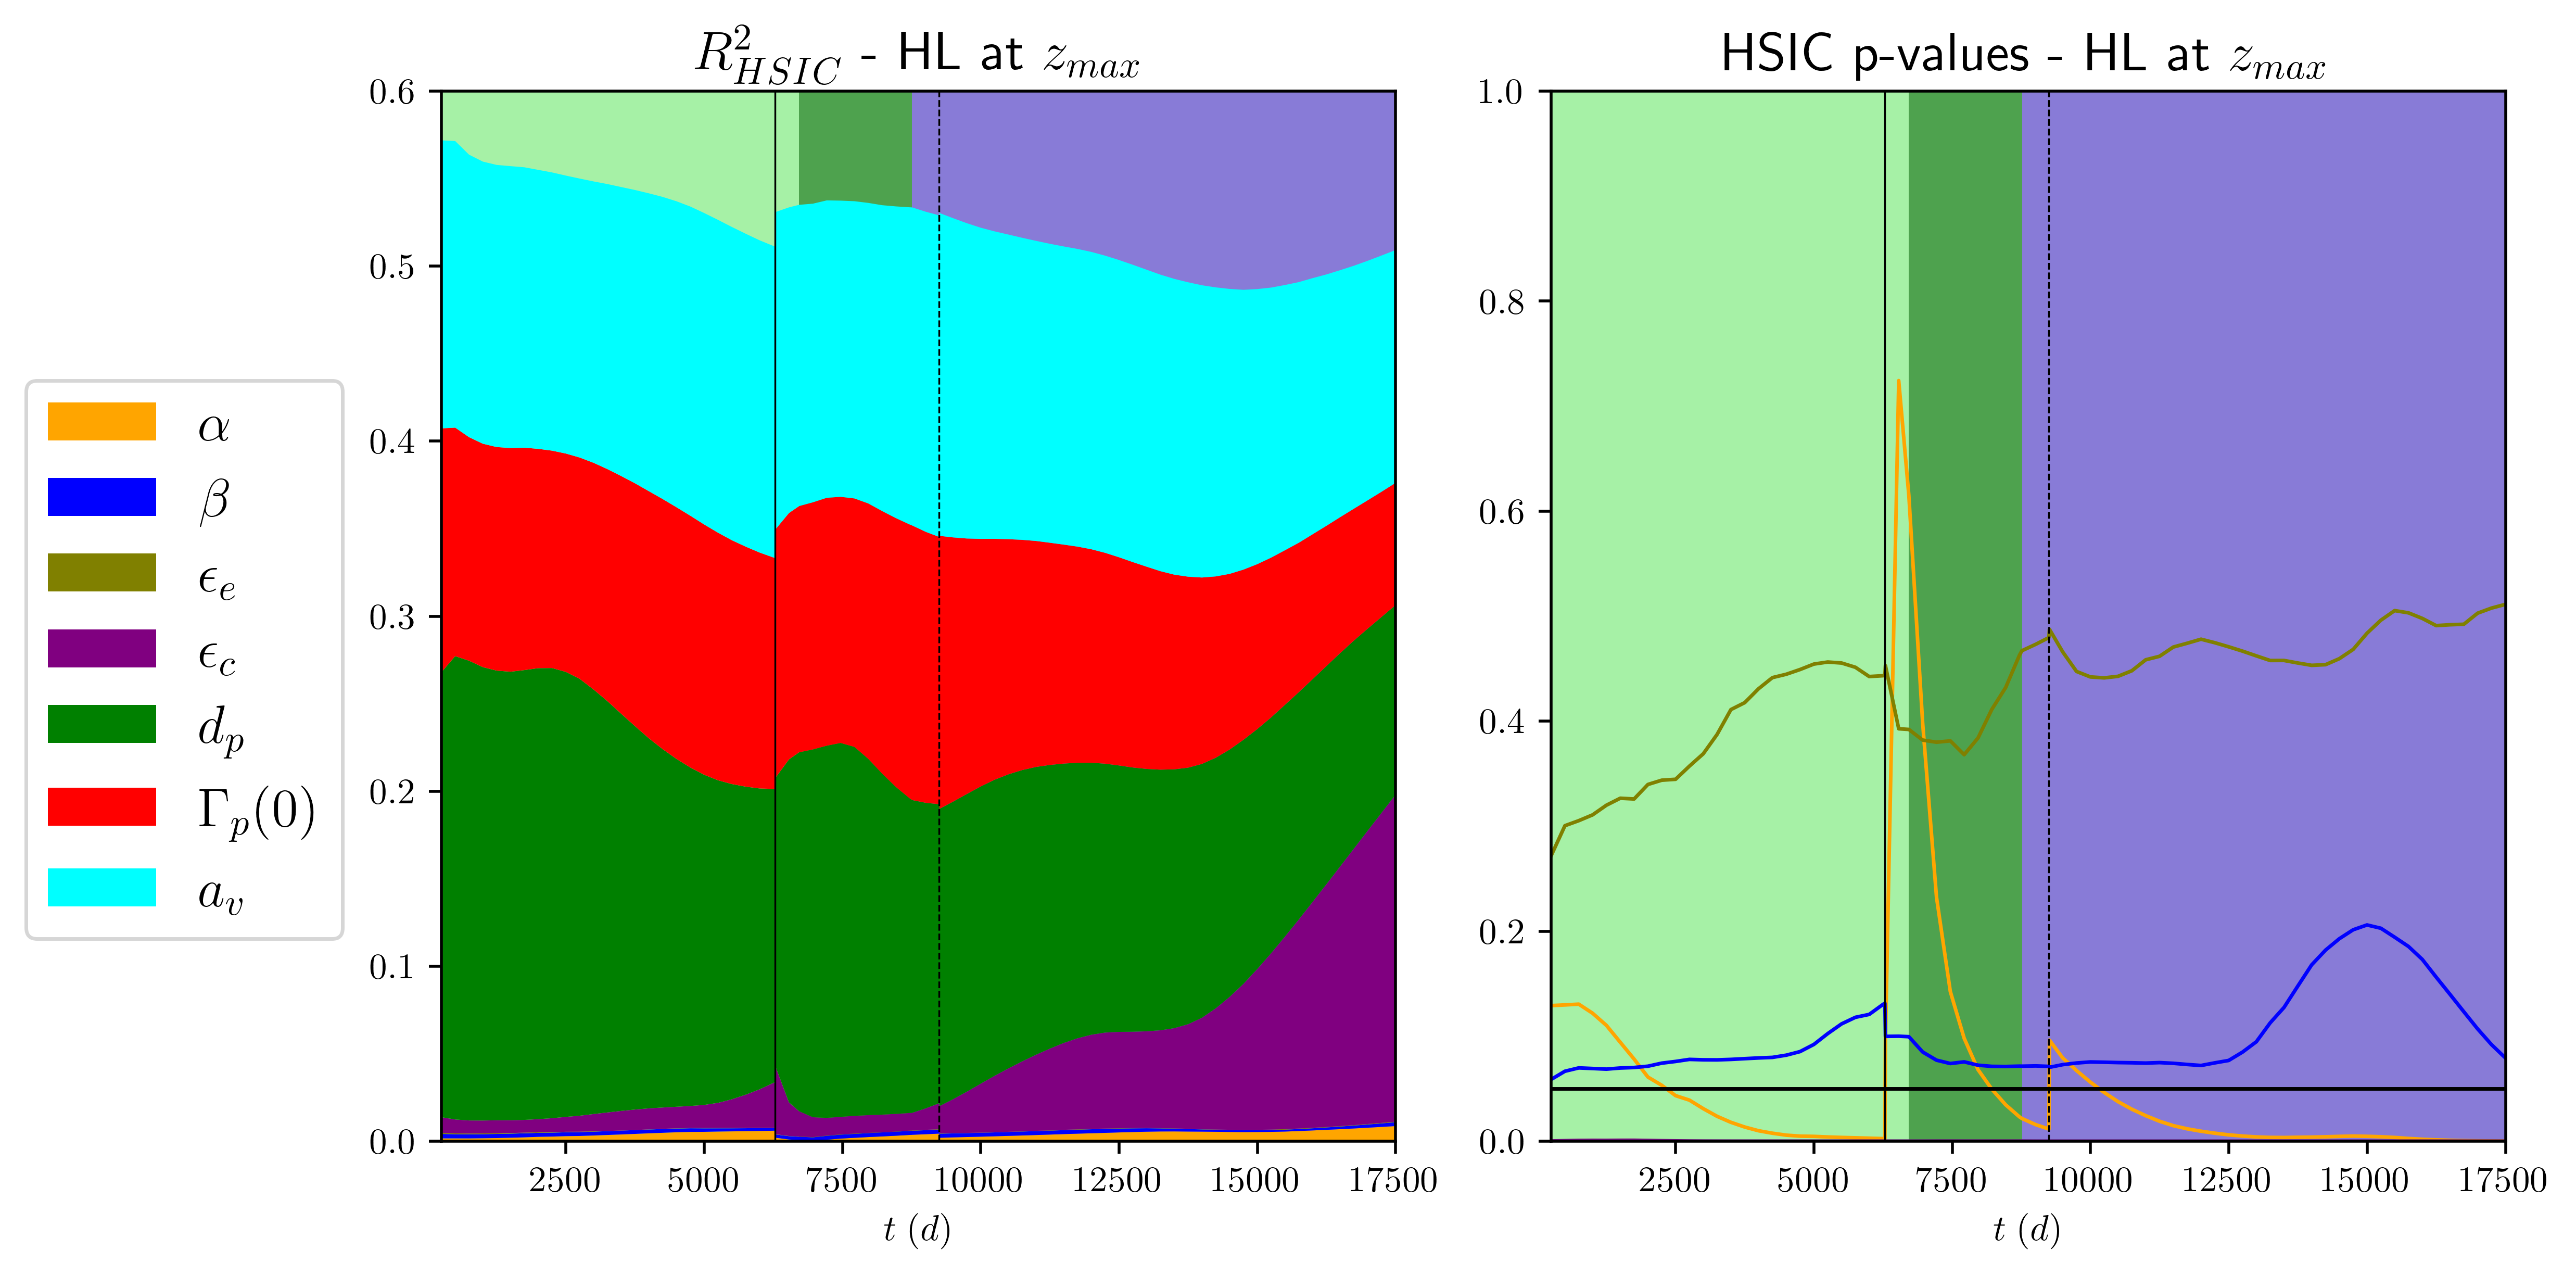

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan']

cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_n[c['type']]
    col = typ[str(c['ph'])]
    axs[0].axvspan(t_i, t_f, facecolor=col, alpha = 0.8)
    axs[1].axvspan(t_i, t_f, facecolor=col, alpha = 0.8)

axs[0].stackplot(t, hsic_time_HL, labels=labels, colors=colors)
axs[0].set_xlim(250,17500)
axs[0].set_ylim(0,0.6)
axs[0].set_xlabel(r'$t\;(d)$')
axs[0].set_title(r'$R^{2}_{HSIC}$ - HL at $z_{max}$', fontsize=15)


for k in range(7):
    axs[1].plot(t, p_values_HL[k], c=colors[k], linewidth=1.0)
axs[1].set_xlim(250,17500)
axs[1].set_ylim(0,1.0)
axs[1].set_xlabel(r'$t\;(d)$')
axs[1].set_title(r'HSIC p-values - HL at $z_{max}$',  fontsize=15)

axs[0].legend(bbox_to_anchor=(-0.075,0.75), fontsize=15)

axs[1].axhline(y=0.05, linewidth=1.0, color='k', label=r'$p=0.05$')


nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        axs[0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventif':
        axs[0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)


fig.savefig('../plots/HSIC/R2_HSIC_tot_asym.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../plots/HSIC/R2_HSIC_tot_asym.png', format='png', bbox_inches='tight')

# Target HSIC for critical target level

In [14]:
tau_levels = [70]
#tau_levels= [30, 50, 70]

In [70]:
hsic_target_diff_time_HL = []
p_values_target_diff_HL = []
#Use the V-stat estimator 
estimatorType_v = ot.HSICVStat() 

In [71]:
size_dataset = []

In [73]:
for tau in tau_levels:
    #Target levels
    dist = ot.DistanceToDomainFunction(ot.Interval(tau, float('inf')))

    hsic_target_HL = []
    p_values_target_HL = []

    size_tau = []

    for i in range(75):

        tauSample_HL = outputSample[:,i]
        sigma = tauSample_HL.computeStandardDeviation()
        func = ot.SymbolicFunction('x', 'exp(- (5 * x)/{0} )'.format(sigma))
        weight = ot.ComposedFunction(func, dist)

        covarianceModelCollection_HL = []
        
        for j in range(7):
            Xi = inputSample.getMarginal(j)
            Cov = ot.SquaredExponential(1)
            Cov.setScale(Xi.computeStandardDeviation())
            covarianceModelCollection_HL.append(Cov)

        covarianceModelCollection_HL.append(ot.SquaredExponential(tauSample_HL.computeStandardDeviation()))

        hsic_v_target_HL = ot.HSICEstimatorTargetSensitivity(covarianceModelCollection_HL, inputSample, tauSample_HL, estimatorType_v, weight)
        
        r2_v_target_HL = hsic_v_target_HL.getR2HSICIndices()

        hsic_target_HL.append(list(np.abs(r2_v_target_HL)))

        a = np.asarray(weight(tauSample_HL))
        #We select quite a lot of points in fact
        b = a[np.where(a >= 0.90)]   

        size_tau.append(b.shape[0])

        #Permutation-based test
        #hsic_v_target_HL.setPermutationSize(500)
        #p_values_target_HL.append(hsic_v_target_HL.getPValuesPermutation())

        #Asymptotic test 1
        #p_values_target_HL.append(hsic_v_target_HL.getPValuesAsymptotic())

        #Asymptotic test 2
        small_p_HL = []
        for j in range(7):
            small_p_HL.append(round(estimatorType_v.computePValue(ot.Gamma(), b.shape[0], hsic_v_target_HL.getR2HSICIndices()[j], 0.0), 4))
        p_values_target_HL.append(small_p_HL)
    
    size_dataset.append(size_tau)
    
    hsic_target_diff_time_HL.append(hsic_target_HL)
    p_values_target_diff_HL.append(p_values_target_HL)

hsic_target_diff_time_HL = np.asarray(hsic_target_diff_time_HL)
p_values_target_diff_HL = np.asarray(p_values_target_diff_HL)
    

In [74]:
p_values_target_diff_HL = np.transpose(p_values_target_diff_HL)

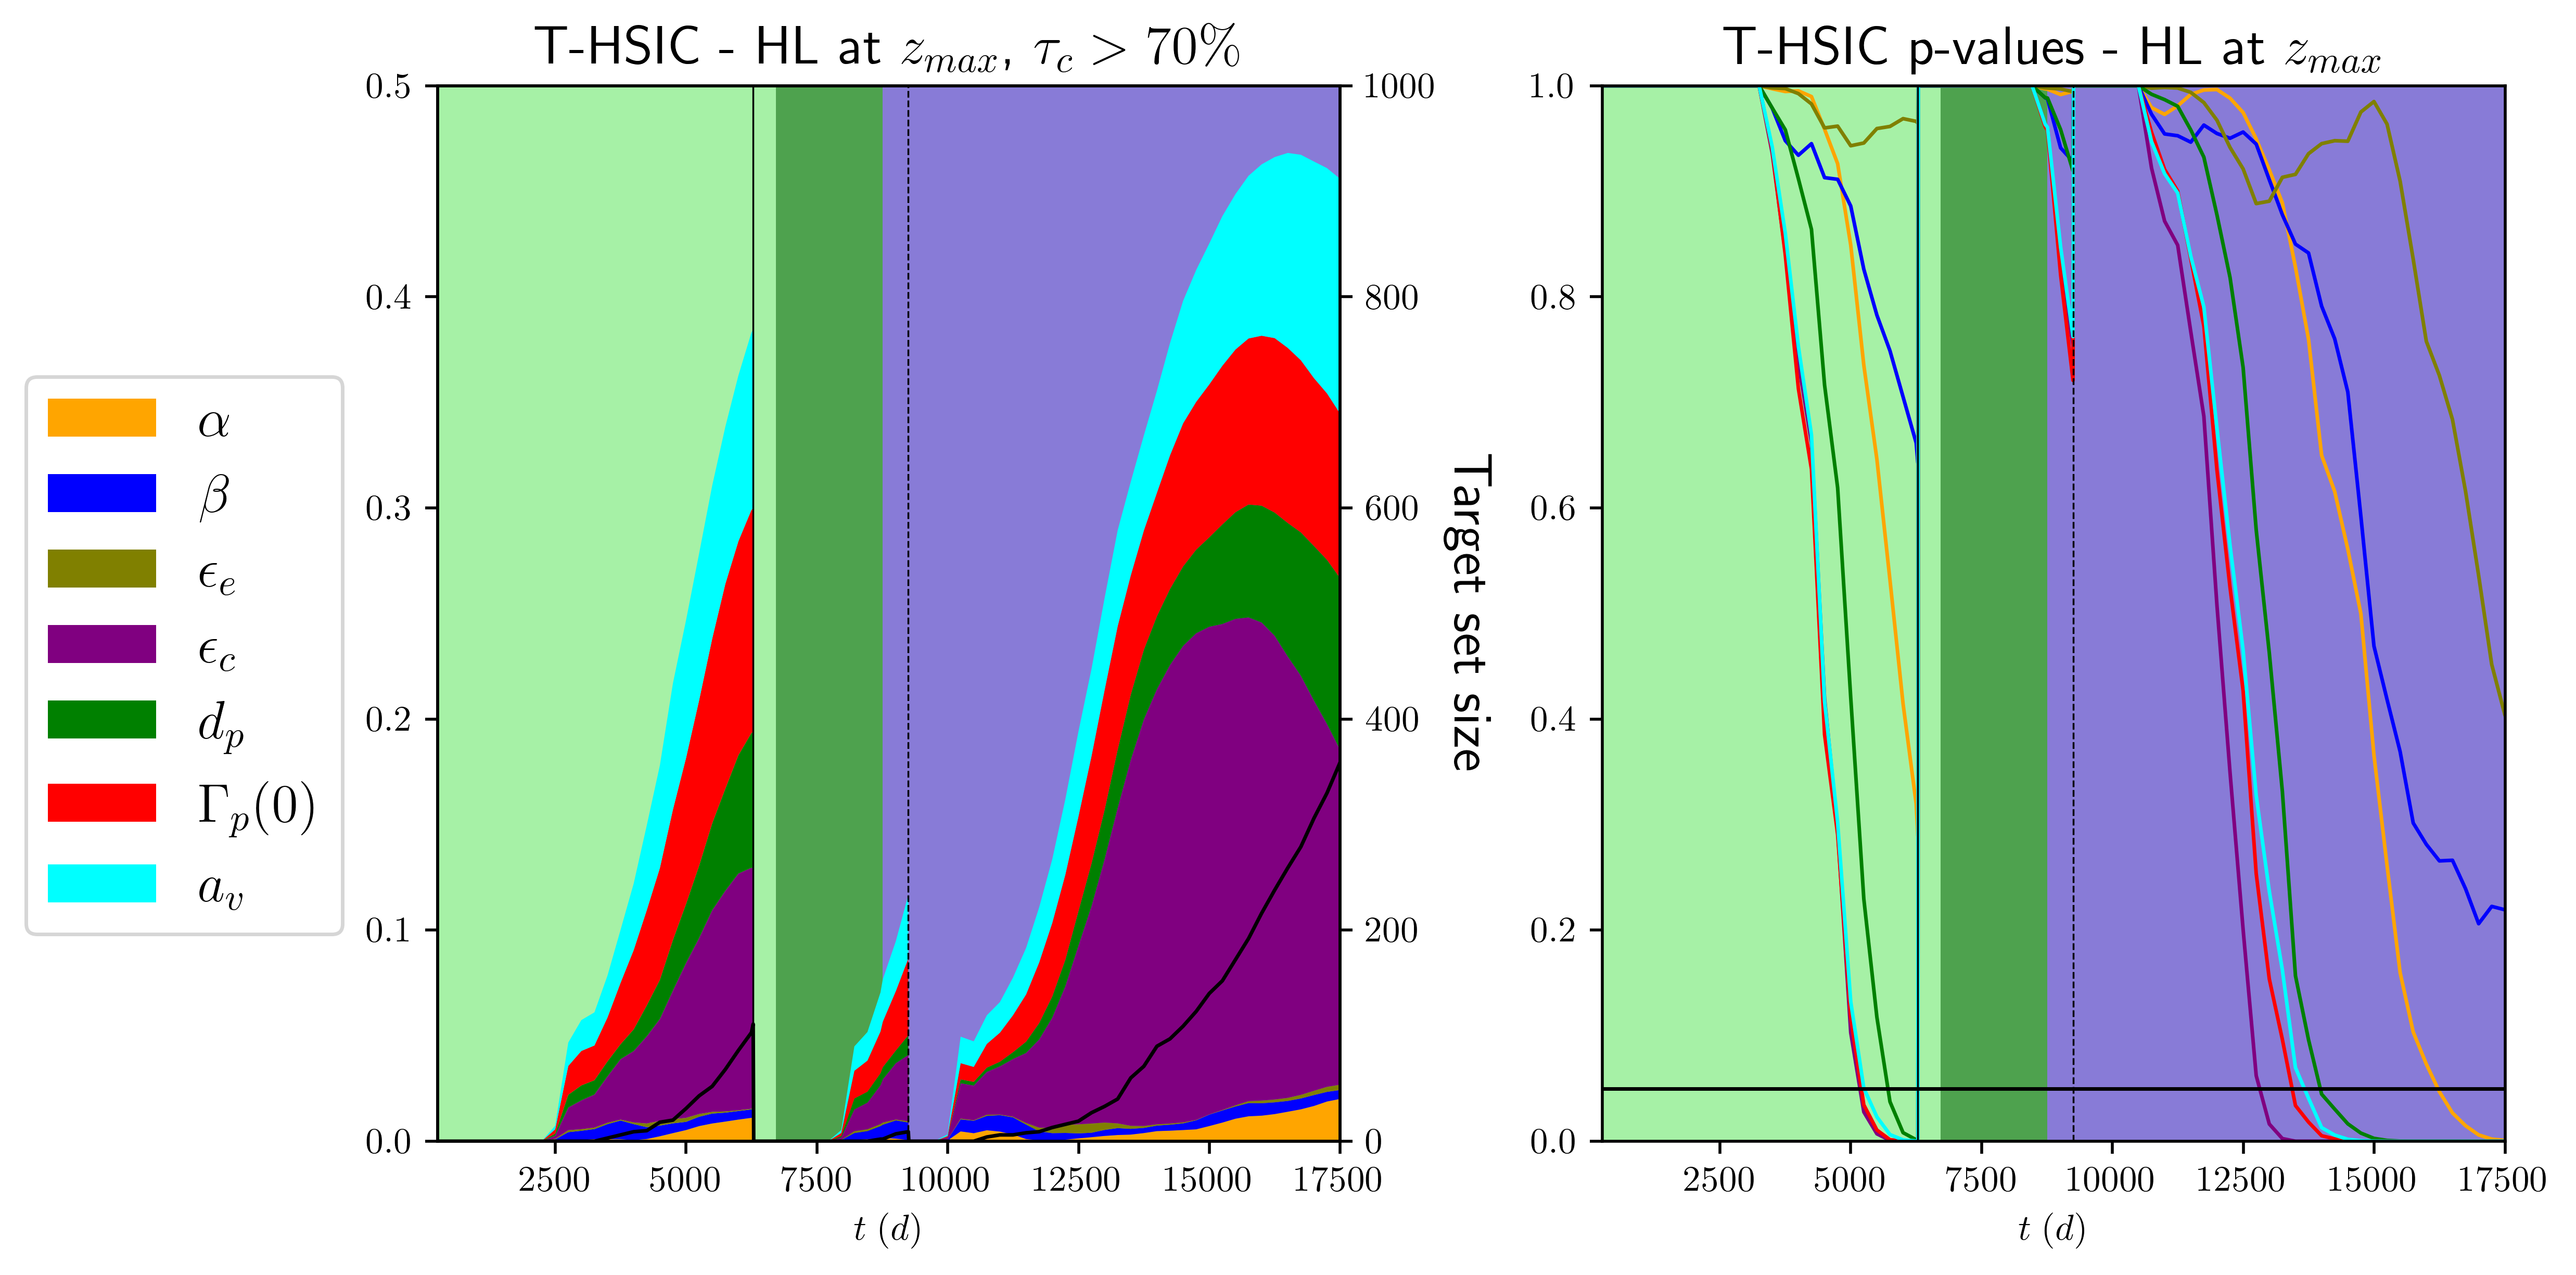

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan']

cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_n[c['type']]
    col = typ[str(c['ph'])]
    axs[0].axvspan(t_i, t_f, facecolor=col, alpha = 0.8)
    axs[1].axvspan(t_i, t_f, facecolor=col, alpha = 0.8)

axs[0].stackplot(t, np.transpose(hsic_target_diff_time_HL[0]), labels=labels, colors=colors)
axs[0].set_xlim(250,17500)
axs[0].set_ylim(0,0.5)
axs[0].set_xlabel(r'$t\;(d)$')
axs[0].set_title(r'T-HSIC - HL at $z_{max}$, $\tau_c > 70\%$', fontsize=15)

ax_ = axs[0].twinx()
ax_.plot(t, size_dataset[0], color = 'k', linewidth=1.0)
ax_.set_xlim(250,17500)
ax_.set_ylim(0,1000)
ax_.set_ylabel('Target set size', fontsize=15, rotation=270, labelpad=15)
ax_.set_ylim(0,1000)

for k in range(7):
    axs[1].plot(t, p_values_target_diff_HL[k], c=colors[k], linewidth=1.0)
axs[1].set_xlim(250,17500)
axs[1].set_ylim(0,1.0)
axs[1].set_xlabel(r'$t\;(d)$')
axs[1].set_title(r'T-HSIC p-values - HL at $z_{max}$',  fontsize=15)

axs[0].legend(bbox_to_anchor=(-0.075,0.75), fontsize=15)

axs[1].axhline(y=0.05, linewidth=1.0, color='k', label=r'$p=0.05$')


nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        axs[0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventif':
        axs[0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)


fig.savefig('../plots/HSIC/R2_HSIC_target.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../plots/HSIC/R2_HSIC_target.png', format='png', bbox_inches='tight')

## For the Hot Leg - HL - Selected target indices variation

In [15]:
target_indices = [3, 5, 7]

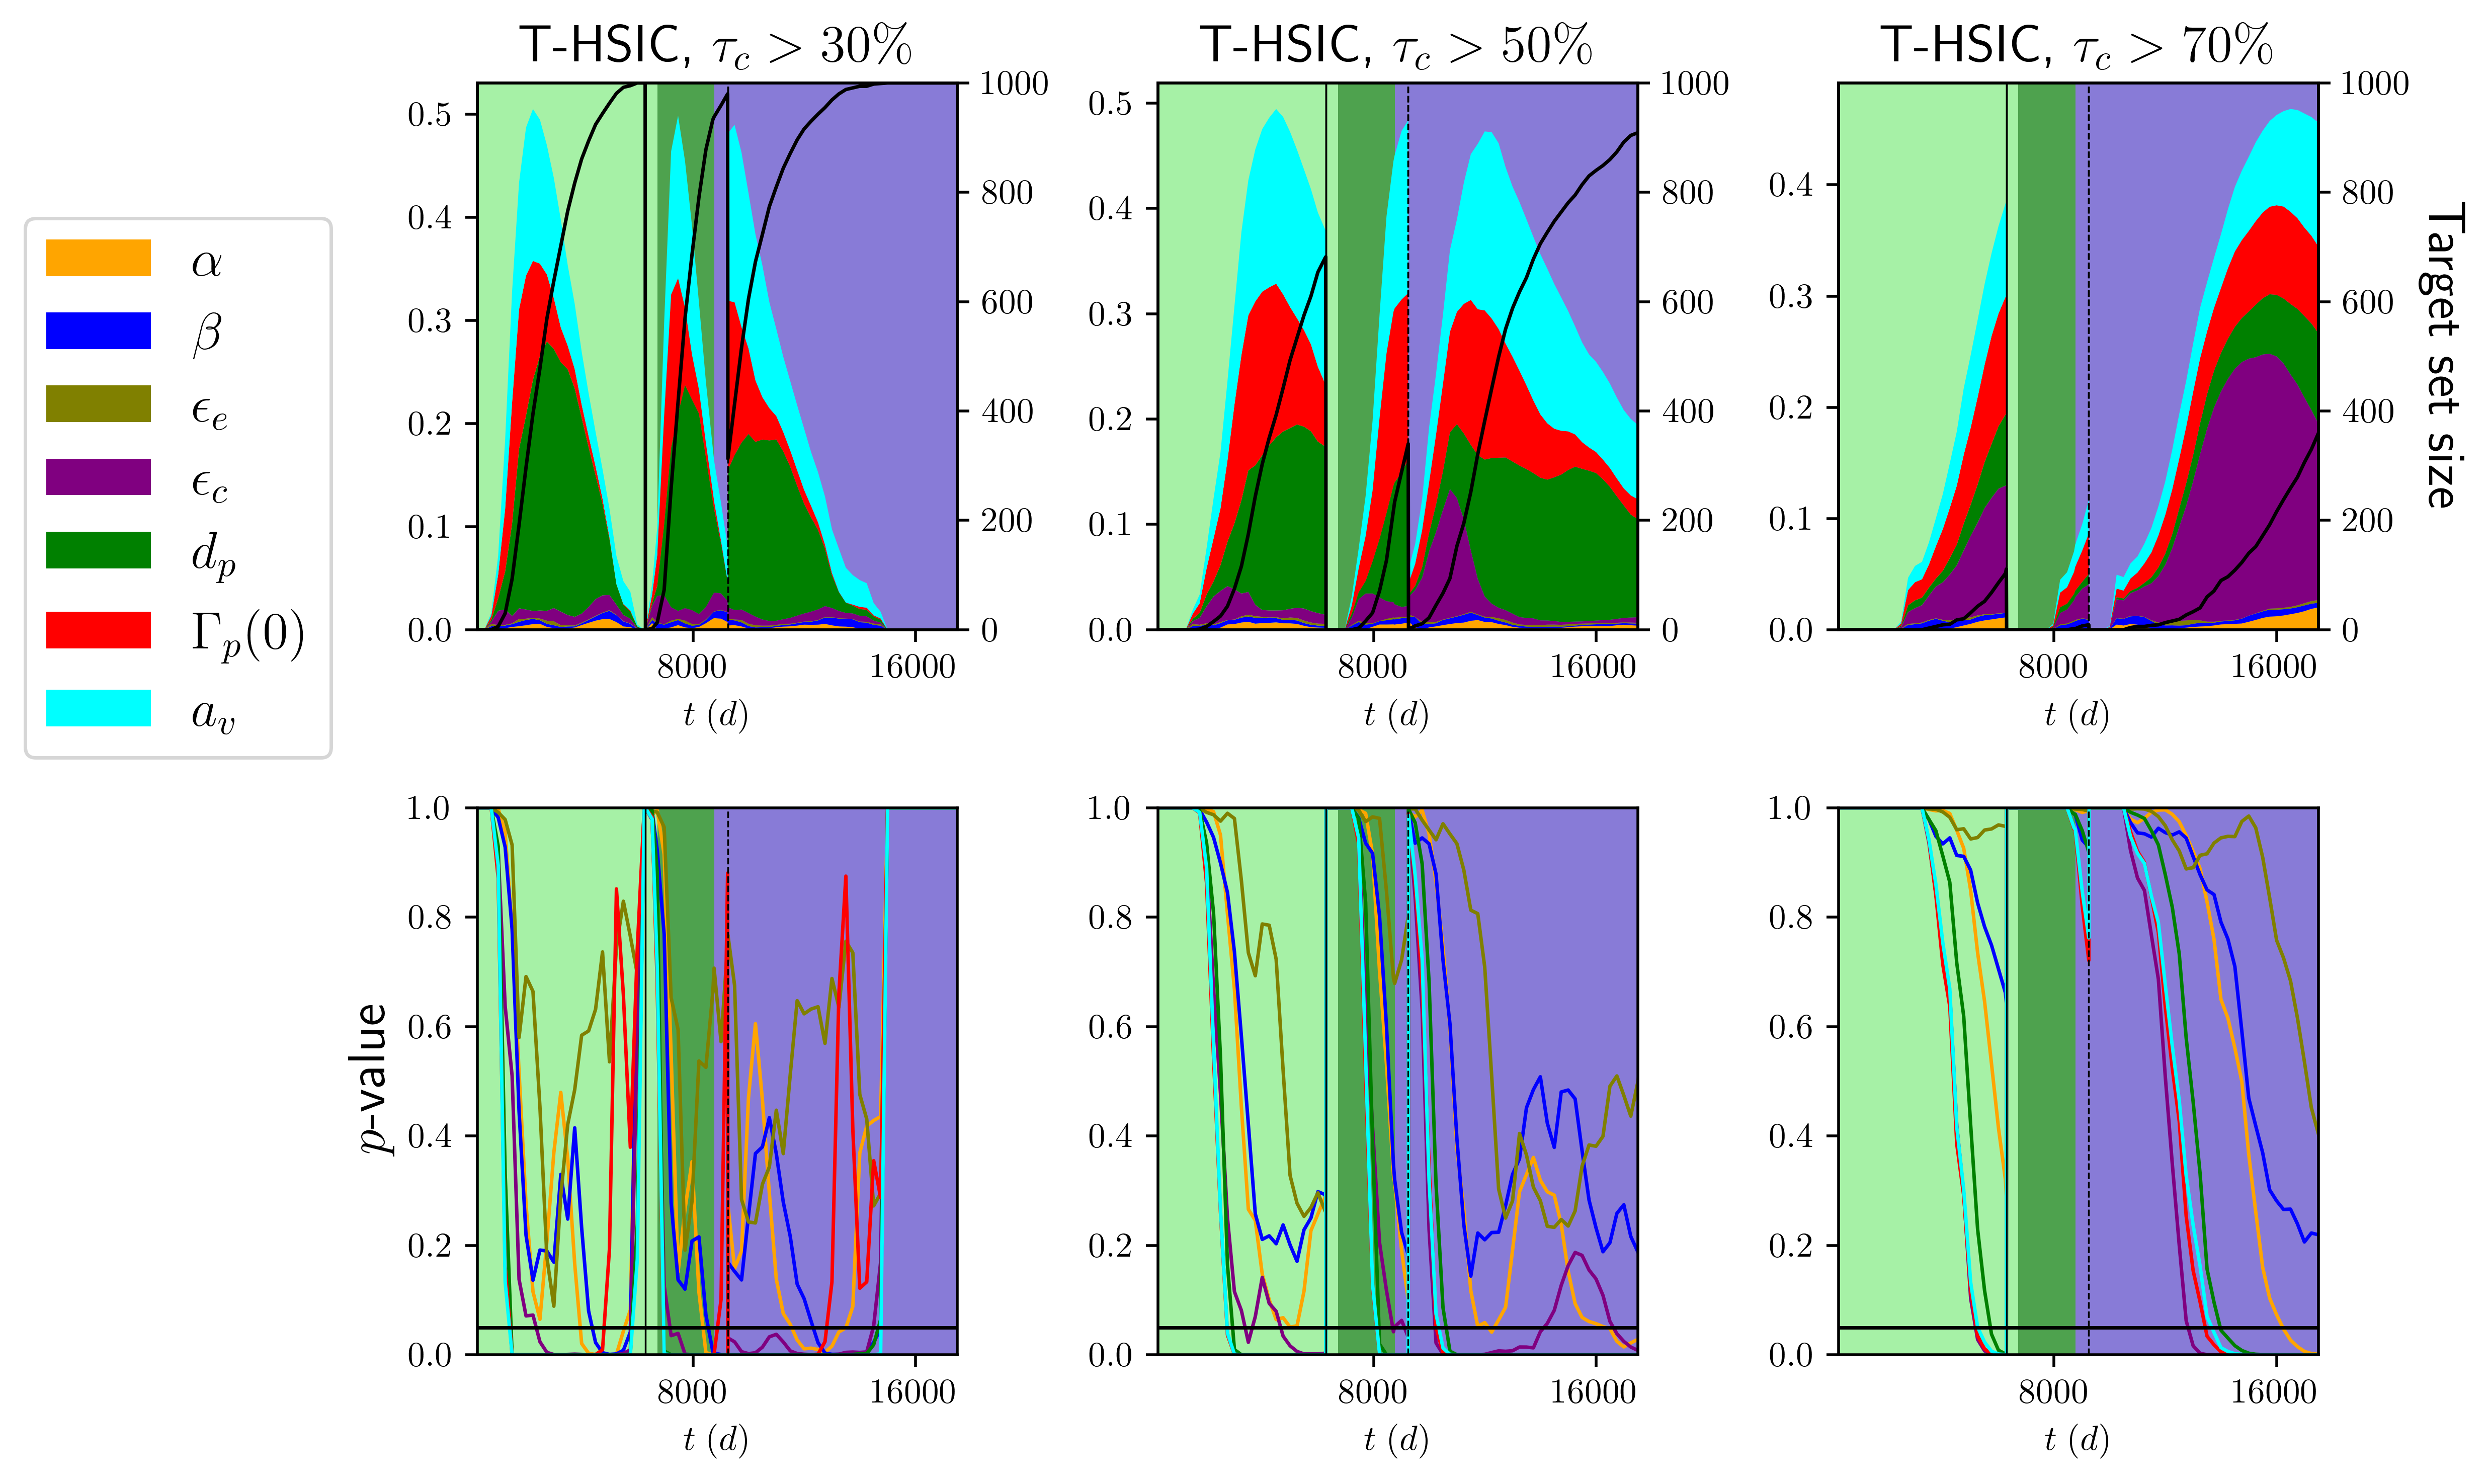

In [17]:
#Plot for different 
nrow, ncol = 2, 3
fig, axs = plt.subplots(nrow, ncol, figsize=(10,6), layout='tight')

colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan']

cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_n[c['type']]
    col = typ[str(c['ph'])]
    for i, ax in enumerate(fig.axes):
        ax.axvspan(t_i, t_f, facecolor=col, alpha = 0.8)

for i in range(len(target_indices)):
    axs[0, i].stackplot(t, hsic_target_diff_time_HL[target_indices[i]].T, labels=labels, colors=colors)
    axs[0, i].set_xlim(250,17500)
    axs[0, i].xaxis.set_major_locator(plt.MaxNLocator(1))
    axs[0, i].set_xlabel(r'$t\;(d)$')
    axs[0, i].set_title(r'T-HSIC, $\tau_c > {}\%$'.format(tau_levels[target_indices[i]]), fontsize=15)

    ax_ = axs[0, i].twinx()
    ax_.plot(t, size_dataset[target_indices[i]], color = 'k', linewidth=1.0)
    ax_.set_xlim(250,17500)
    ax_.set_ylim(0,1000)
    if i == 2:
        ax_.set_ylabel('Target set size', fontsize=15, rotation=270, labelpad=15)
        ax_.set_ylim(0,1000)

    for j in range(7):
        axs[1, i].plot(t, p_values_target_diff_HL[target_indices[i]].T[j], label=labels[k], c=colors[j], linewidth=1.0)
        axs[1, i].set_xlim(250,17500)
        axs[1, i].xaxis.set_major_locator(plt.MaxNLocator(1))
        axs[1, i].set_xlabel(r'$t\;(d)$')
        axs[1, i].axhline(y=0.05, linewidth=1.0, color='k', label=r'$p=0.05$')
    axs[1, i].set_ylim(0.0, 1.0)
    axs[1,0].set_ylabel(r'$p$-value', fontsize=15)

nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        for i, ax in enumerate(fig.axes):
            ax.axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)

    elif nett[k]['type'] == 'preventif':
        for i, ax in enumerate(fig.axes):
            ax.axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)

axs[0,0].legend(bbox_to_anchor=(-0.25,0.8), fontsize=15)
#fig.suptitle(r'HL - $R^2_{T-HSIC}$ - $p$-values, as a function of time.', fontsize=10)

fig.savefig('../plots/HSIC/HL_target_HSIC.pdf', format='pdf')
fig.savefig('../plots/HSIC/HL_target_HSIC.png', format='png')
        

# Conditional HSIC for different clogging levels

In [28]:
hsic_cond_diff_time_HL = []
p_values_cond_diff_HL = []
#Use of V-stat only here
estimatorType_v = ot.HSICVStat() 

In [29]:
size_dataset_cond = []

In [30]:
for tau in tau_levels:
    #Target levels
    dist = ot.DistanceToDomainFunction(ot.Interval(tau, float('inf')))

    hsic_cond_HL = []
    p_values_cond_HL = []

    size_tau = []

    for i in range(75):

        tauSample_HL = outputSample[:,i]
        sigma = tauSample_HL.computeStandardDeviation()
        func = ot.SymbolicFunction('x', 'exp(- (5 * x)/{0} )'.format(sigma))
        weight = ot.ComposedFunction(func, dist)

        covarianceModelCollection_HL = []
        
        for j in range(7):
            Xi = inputSample.getMarginal(j)
            Cov = ot.SquaredExponential(1)
            Cov.setScale(Xi.computeStandardDeviation())
            covarianceModelCollection_HL.append(Cov)

        covarianceModelCollection_HL.append(ot.SquaredExponential(tauSample_HL.computeStandardDeviation()))

        hsic_v_cond_HL = ot.HSICEstimatorConditionalSensitivity(covarianceModelCollection_HL, inputSample, tauSample_HL, weight)
        
        r2_v_cond_HL = hsic_v_cond_HL.getR2HSICIndices()

        hsic_cond_HL.append(list(np.abs(r2_v_cond_HL)))

        small_p_HL = []

        a = np.asarray(weight(tauSample_HL))
        #We select quite a lot of points in fact
        b = a[np.where(a >= 0.90)]   

        size_tau.append(b.shape[0])

        #Permutation-based test
        #hsic_v_cond_HL.setPermutationSize(500)
        #p_values_cond_HL.append(hsic_v_cond_HL.getPValuesPermutation())

        #Asymptotic test
        p_values_cond_HL.append(hsic_v_cond_HL.getPValuesAsymptotic())

        #Asymptotic test 2
        #for j in range(7):
        #    small_p_HL.append(round(estimatorType_v.computePValue(ot.Gamma(), b.shape[0], hsic_v_cond_HL.getR2HSICIndices()[j], 0.0),4))
        #p_values_cond_HL.append(small_p_HL)

    size_dataset_cond.append(size_tau)
    
    hsic_cond_diff_time_HL.append(hsic_cond_HL)
    p_values_cond_diff_HL.append(p_values_cond_HL)
    

RuntimeError: NotYetImplementedException : HSICEstimatorConditionalSensitivity cannot compute asymptotic p-values.

## For the Hot Leg - HL

In [79]:
hsic_cond_diff_time_HL = np.asarray(hsic_cond_diff_time_HL)
p_values_cond_diff_HL = np.transpose(np.asarray(p_values_cond_diff_HL))

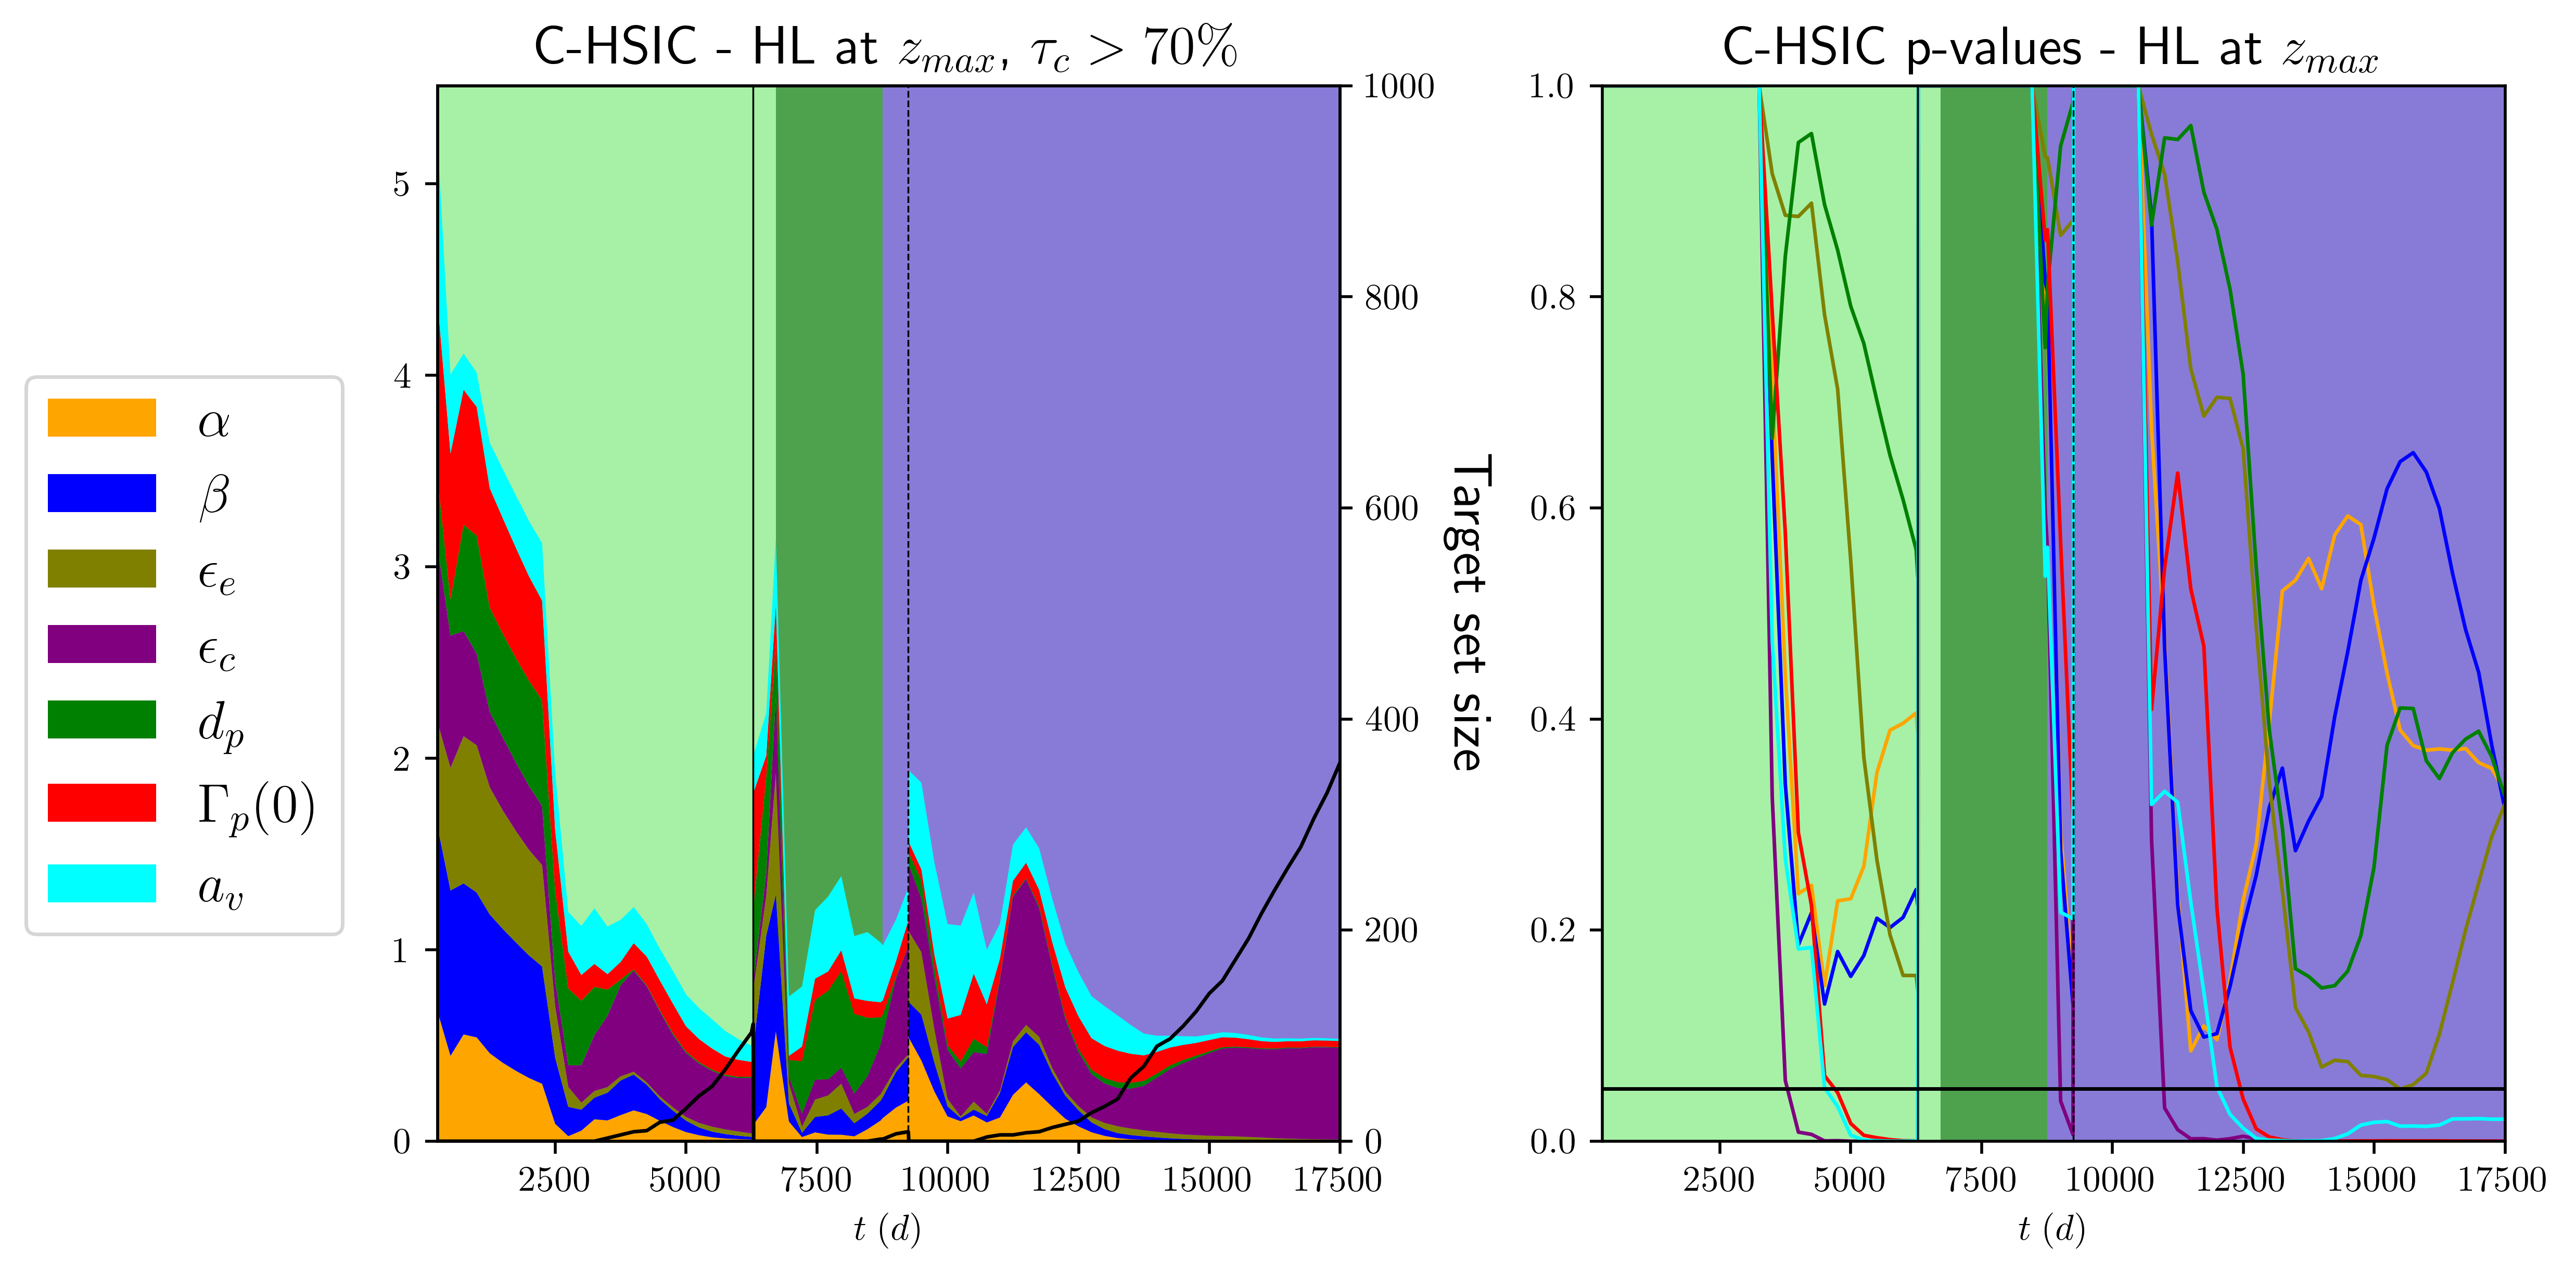

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan']

cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_n[c['type']]
    col = typ[str(c['ph'])]
    axs[0].axvspan(t_i, t_f, facecolor=col, alpha = 0.8)
    axs[1].axvspan(t_i, t_f, facecolor=col, alpha = 0.8)

axs[0].stackplot(t, np.transpose(hsic_cond_diff_time_HL[0]), labels=labels, colors=colors)
axs[0].set_xlim(250,17500)
#axs[0].set_ylim(0,0.5)
axs[0].set_xlabel(r'$t\;(d)$')
axs[0].set_title(r'C-HSIC - HL at $z_{max}$, $\tau_c > 70\%$', fontsize=15)

ax_ = axs[0].twinx()
ax_.plot(t, size_dataset[0], color = 'k', linewidth=1.0)
ax_.set_xlim(250,17500)
ax_.set_ylim(0,1000)
ax_.set_ylabel('Target set size', fontsize=15, rotation=270, labelpad=15)
ax_.set_ylim(0,1000)

for k in range(7):
    axs[1].plot(t, p_values_cond_diff_HL[k], c=colors[k], linewidth=1.0)
axs[1].set_xlim(250,17500)
axs[1].set_ylim(0,1.0)
axs[1].set_xlabel(r'$t\;(d)$')
axs[1].set_title(r'C-HSIC p-values - HL at $z_{max}$',  fontsize=15)

axs[0].legend(bbox_to_anchor=(-0.075,0.75), fontsize=15)

axs[1].axhline(y=0.05, linewidth=1.0, color='k', label=r'$p=0.05$')


nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        axs[0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventif':
        axs[0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)


fig.savefig('../plots/HSIC/R2_HSIC_cond.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../plots/HSIC/R2_HSIC_cond.png', format='png', bbox_inches='tight')

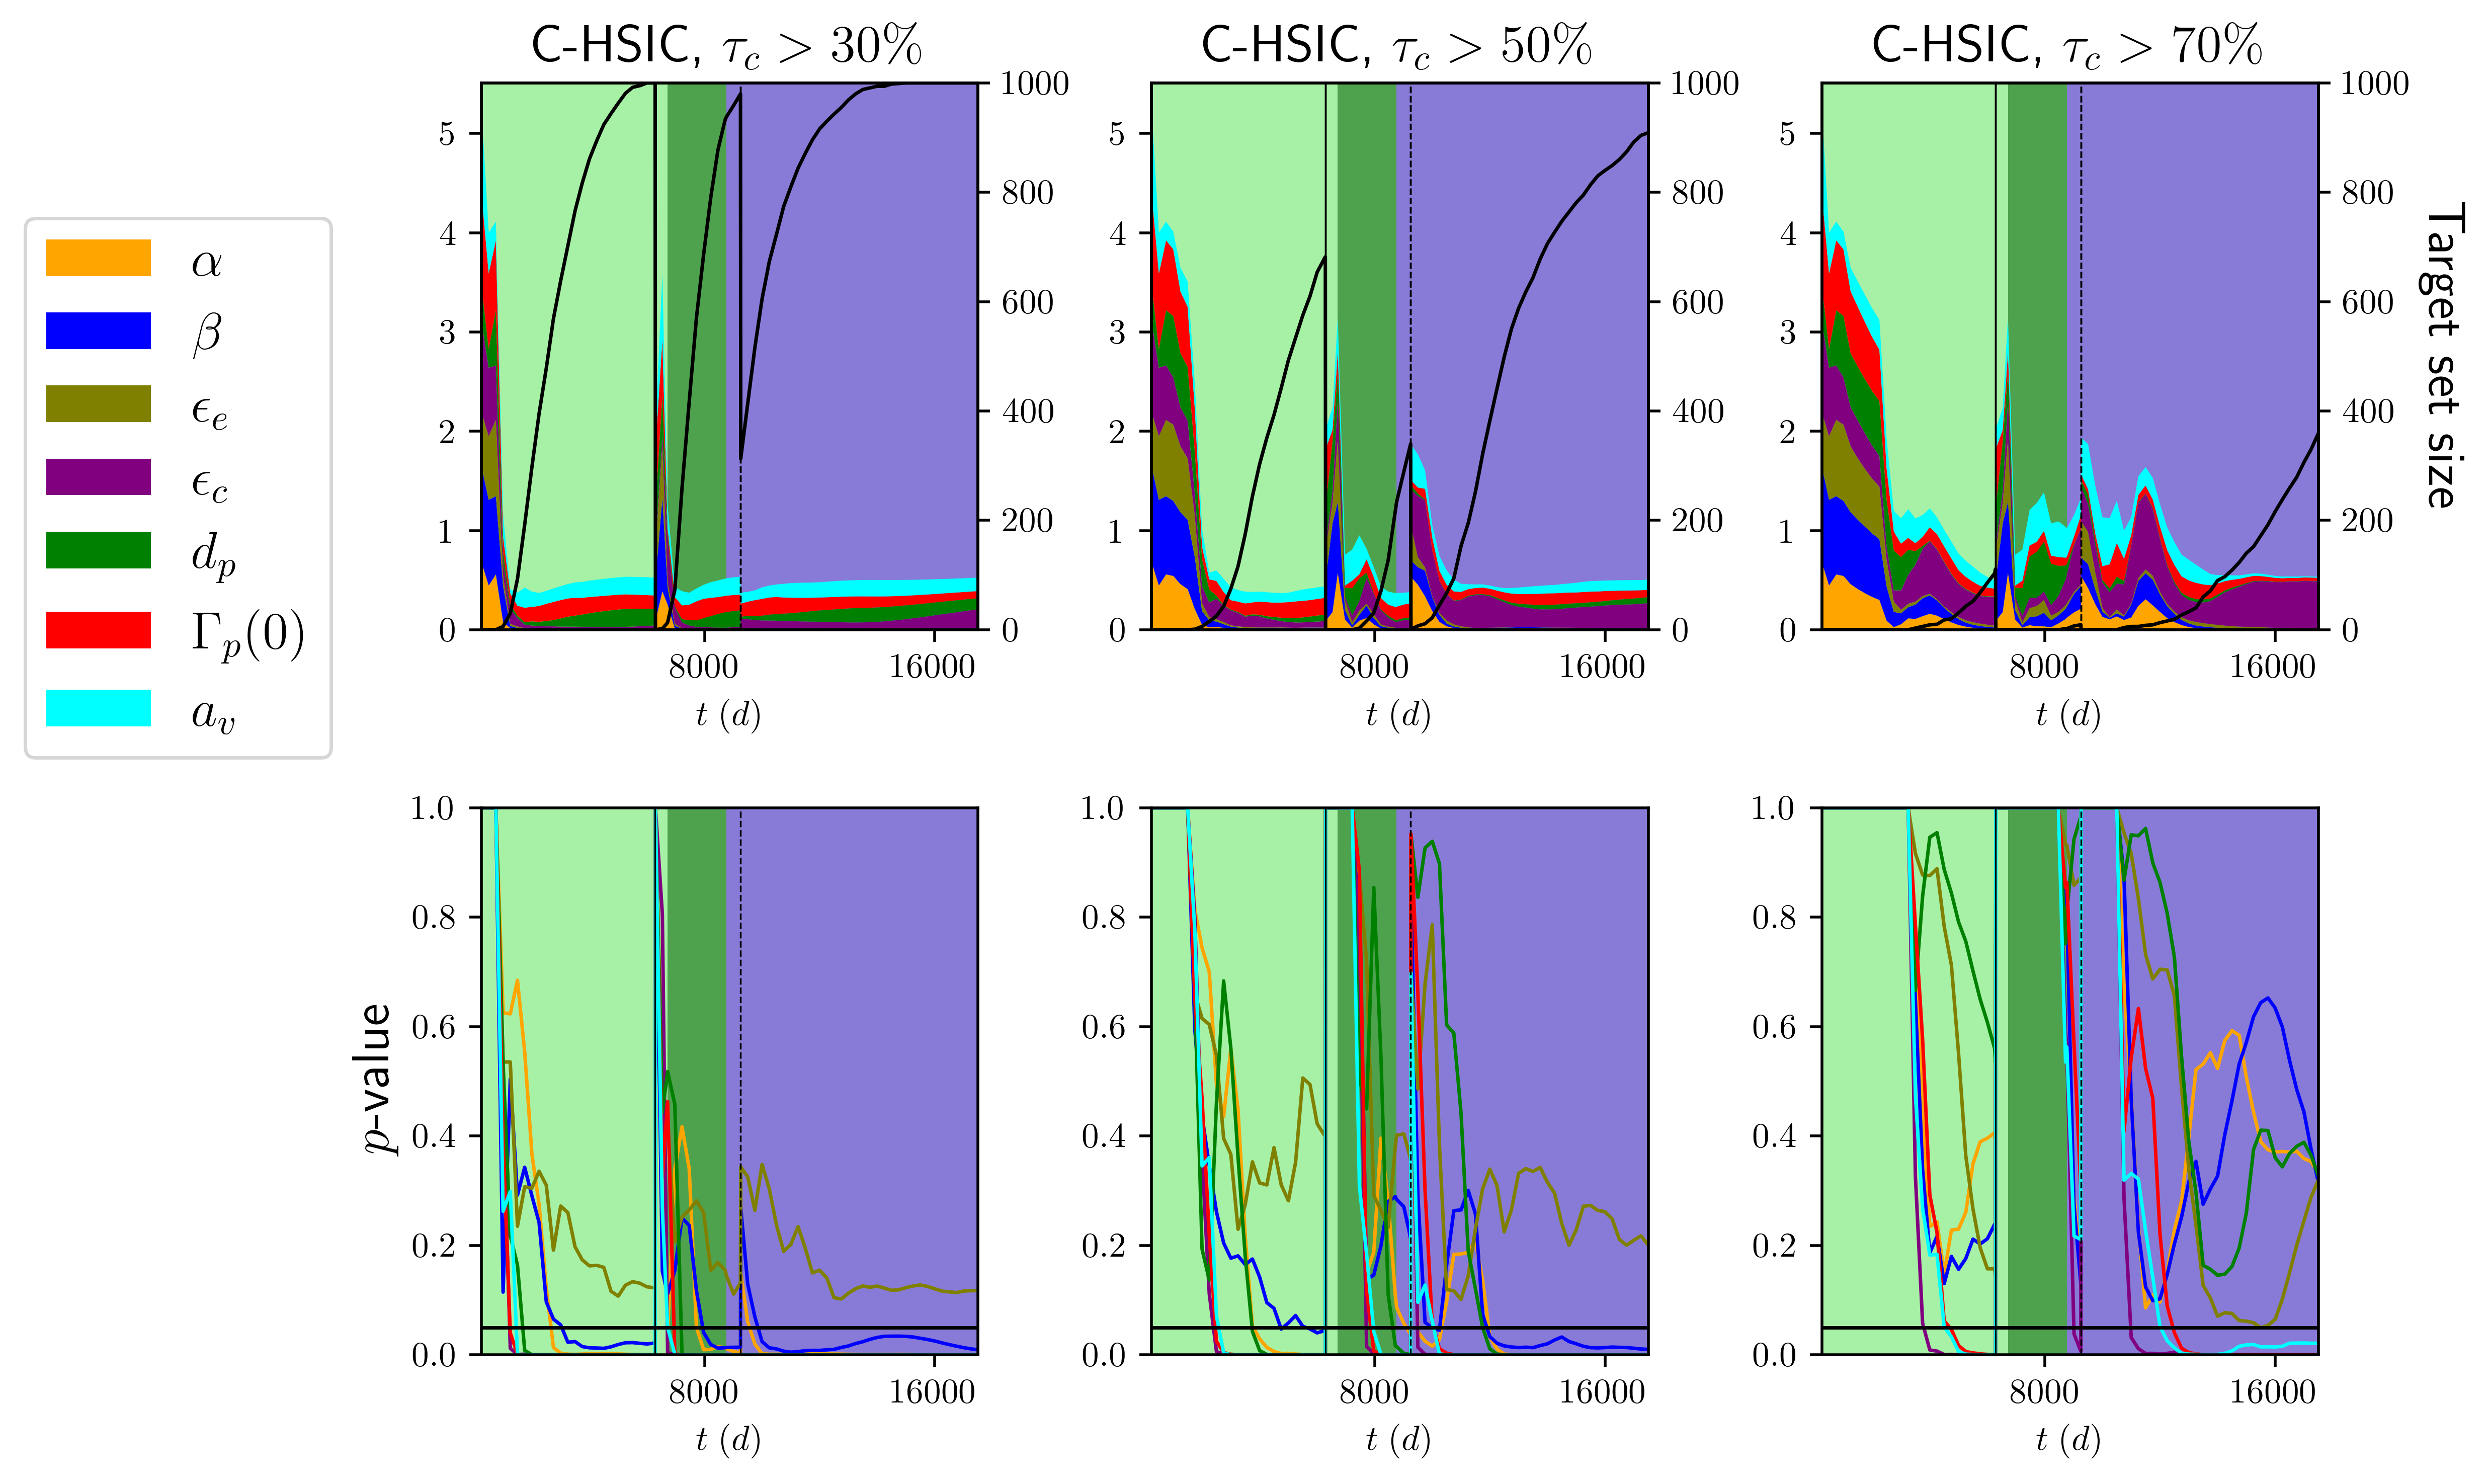

In [22]:
#Plot for different 
nrow, ncol = 2, 3
fig, axs = plt.subplots(nrow, ncol, figsize=(10,6), layout='tight')

colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan']

cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_n[c['type']]
    col = typ[str(c['ph'])]
    for i, ax in enumerate(fig.axes):
        ax.axvspan(t_i, t_f, facecolor=col, alpha = 0.8)

for i in range(len(target_indices)):
    axs[0, i].stackplot(t, hsic_cond_diff_time_HL[target_indices[i]].T, labels=labels, colors=colors)
    axs[0, i].set_xlim(250,17500)
    axs[0, i].xaxis.set_major_locator(plt.MaxNLocator(1))
    axs[0, i].set_xlabel(r'$t\;(d)$')
    axs[0, i].set_title(r'C-HSIC, $\tau_c > {}\%$'.format(tau_levels[target_indices[i]]), fontsize=15)

    ax_ = axs[0, i].twinx()
    ax_.plot(t, size_dataset_cond[target_indices[i]], color = 'k', linewidth=1.0)
    ax_.set_xlim(250,17500)
    ax_.set_ylim(0,1000)
    if i == 2:
        ax_.set_ylabel('Target set size', fontsize=15, rotation=270, labelpad=15)
        ax_.set_ylim(0,1000)

    for j in range(7):
        axs[1, i].plot(t, p_values_cond_diff_HL[target_indices[i]].T[j], label=labels[k], c=colors[j], linewidth=1.0)
        axs[1, i].set_xlim(250,17500)
        axs[1, i].xaxis.set_major_locator(plt.MaxNLocator(1))
        axs[1, i].set_xlabel(r'$t\;(d)$')
        axs[1, i].axhline(y=0.05, linewidth=1.0, color='k', label=r'$p=0.05$')
    axs[1, i].set_ylim(0.0, 1.0)
    axs[1,0].set_ylabel(r'$p$-value', fontsize=15)

nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        for i, ax in enumerate(fig.axes):
            ax.axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)

    elif nett[k]['type'] == 'preventif':
        for i, ax in enumerate(fig.axes):
            ax.axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)

axs[0,0].legend(bbox_to_anchor=(-0.25,0.8), fontsize=15)
#fig.suptitle(r'HL - $R^2_{T-HSIC}$ - $p$-values, as a function of time.', fontsize=10)

fig.savefig('../plots/HSIC/HL_cond_HSIC.pdf', format='pdf')
fig.savefig('../plots/HSIC/HL_cond_HSIC.png', format='png')
        